In [1]:
#Phase 1: Data Exploration & Preprocessing

import pandas as pd
import os

# Function to load OULAD data from CSV files
# Using raw strings to handle backslashes in Windows file paths
# This function assumes the CSV files are located in the specified directory
# and that the directory structure matches the expected format.

def load_oulad_data(data_path):
    """Load all OULAD CSV files into pandas DataFrames"""

    # Core tables - using raw strings
    courses = pd.read_csv(rf"{data_path}\courses.csv")
    assessments = pd.read_csv(rf"{data_path}\assessments.csv")
    vle = pd.read_csv(rf"{data_path}\vle.csv")

    # Student data
    student_info = pd.read_csv(rf"{data_path}\studentInfo.csv")
    student_registration = pd.read_csv(rf"{data_path}\studentRegistration.csv")
    student_assessment = pd.read_csv(rf"{data_path}\studentAssessment.csv")
    student_vle = pd.read_csv(rf"{data_path}\studentVle.csv")

    return {
        'courses': courses,
        'assessments': assessments,
        'vle': vle,
        'student_info': student_info,
        'student_registration': student_registration,
        'student_assessment': student_assessment,
        'student_vle': student_vle
    }

# Load the data - use raw string for path
oulad_data = load_oulad_data(r"C:\Users\Ritam\Projects\XAIDashboard\dataset")

In [19]:
#data exploration
# Function to explore the main student information table
def explore_student_data(oulad_data):
    """Explore the main student information table"""

    student_info = oulad_data['student_info']

    print("=== STUDENT INFO EXPLORATION ===")
    print(f"Shape: {student_info.shape}")
    print(f"Columns: {list(student_info.columns)}")
    print("\n--- Sample Data ---")
    print(student_info.head(3))

    print("\n--- Target Variable Distribution ---")
    print(student_info['final_result'].value_counts())
    print(student_info['final_result'].value_counts(normalize=True).round(3))

    print("\n--- Demographic Breakdown ---")
    print("Gender:", student_info['gender'].value_counts().to_dict())
    print("Age bands:", student_info['age_band'].value_counts().to_dict())
    print("Disability:", student_info['disability'].value_counts().to_dict())

# Run exploration
explore_student_data(oulad_data)

=== STUDENT INFO EXPLORATION ===
Shape: (32593, 12)
Columns: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result']

--- Sample Data ---
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N         Pass  
2               

In [2]:
#Check VLE Engagement Patterns
def explore_vle_data(oulad_data):
    """Explore VLE interaction patterns"""

    student_vle = oulad_data['student_vle']

    print("=== VLE INTERACTION EXPLORATION ===")
    print(f"Total interactions: {len(student_vle):,}")
    print(f"Unique students with VLE data: {student_vle['id_student'].nunique():,}")

    # Basic statistics
    print(f"Clicks per interaction - Mean: {student_vle['sum_click'].mean():.1f}, Max: {student_vle['sum_click'].max()}")

    # Activity patterns
    activity_types = oulad_data['vle']['activity_type'].value_counts().head(10)
    print("\n--- Top Activity Types ---")
    print(activity_types)

# Run VLE exploration
explore_vle_data(oulad_data)



=== VLE INTERACTION EXPLORATION ===
Total interactions: 10,655,280
Unique students with VLE data: 26,074
Clicks per interaction - Mean: 3.7, Max: 6977

--- Top Activity Types ---
activity_type
resource         2660
subpage          1055
oucontent         996
url               886
forumng           194
quiz              127
page              102
oucollaborate      82
questionnaire      61
ouwiki             49
Name: count, dtype: int64


In [3]:
#Assess Data Quality
def assess_data_quality(oulad_data):
    """Quick data quality assessment"""

    print("=== DATA QUALITY ASSESSMENT ===")

    for table_name, df in oulad_data.items():
        missing_pct = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
        print(f"{table_name}: {missing_pct:.1f}% missing values")

        if missing_pct > 0:
            missing_cols = df.isnull().sum()
            critical_missing = missing_cols[missing_cols > len(df) * 0.1]  # >10% missing
            if len(critical_missing) > 0:
                print(f"  ⚠️  High missingness in: {critical_missing.to_dict()}")

# Run quality assessment
assess_data_quality(oulad_data)


=== DATA QUALITY ASSESSMENT ===
courses: 0.0% missing values
assessments: 0.9% missing values
vle: 27.5% missing values
  ⚠️  High missingness in: {'week_from': 5243, 'week_to': 5243}
student_info: 0.3% missing values
student_registration: 13.8% missing values
  ⚠️  High missingness in: {'date_unregistration': 22521}
student_assessment: 0.0% missing values
student_vle: 0.0% missing values


In [4]:
# VLE Table: week_from and week_to (27.5% missing)
def handle_vle_missing(vle_data):
    """Handle missing week data in VLE table"""

    # Strategy 1: Create 'continuous' category for missing weeks
    vle_data['week_from'] = vle_data['week_from'].fillna(-1)  # -1 = continuous
    vle_data['week_to'] = vle_data['week_to'].fillna(-1)

    # Strategy 2: Create boolean flag for continuous activities
    vle_data['is_continuous_activity'] = vle_data['week_from'].isna()

    # Strategy 3: Fill with course-wide availability (0 to max_week)
    max_week = vle_data['week_to'].max()
    vle_data['week_from_filled'] = vle_data['week_from'].fillna(0)
    vle_data['week_to_filled'] = vle_data['week_to'].fillna(max_week)

    return vle_data

#Student Registration: date_unregistration (13.8% missing)
def handle_registration_missing(registration_data):
    """Handle missing unregistration dates"""

    # Strategy 1: Create binary completion indicator
    registration_data['completed_course'] = registration_data['date_unregistration'].isna()

    # Strategy 2: Fill with end-of-course date for completed students
    # (You can get course end dates from course table)
    registration_data['unregistration_status'] = registration_data['date_unregistration'].apply(
        lambda x: 'completed' if pd.isna(x) else 'withdrew'
    )

    # Strategy 3: Calculate retention days (for non-missing values)
    registration_data['retention_days'] = (
        registration_data['date_unregistration'] - registration_data['date_registration']
    ).dt.days

    return registration_data


In [5]:
#Handle all missing values comprehensively
def comprehensive_missing_value_handling(oulad_data):
    """Complete strategy for handling all missing values"""

    print("=== HANDLING MISSING VALUES ===")

    # 1. VLE table - handle week missingness
    print("Processing VLE missing values...")
    vle = oulad_data['vle'].copy()

    # Create flags for continuous activities
    vle['is_continuous'] = vle['week_from'].isna()

    # Fill with meaningful values
    vle['week_from'] = vle['week_from'].fillna(0)  # Start of course
    vle['week_to'] = vle['week_to'].fillna(vle['week_to'].max())  # End of course

    oulad_data['vle'] = vle
    print(f"✅ VLE: Added continuous activity flags")

    # 2. Student registration - handle unregistration missingness
    print("Processing registration missing values...")
    registration = oulad_data['student_registration'].copy()

    # Create completion indicators
    registration['completed_course'] = registration['date_unregistration'].isna()
    registration['withdrawal_status'] = registration['date_unregistration'].apply(
        lambda x: 'completed' if pd.isna(x) else 'withdrew_early'
    )

    oulad_data['student_registration'] = registration
    print(f"✅ Registration: Added completion indicators")

    # 3. Handle minor missing values in other tables
    print("Processing minor missing values...")

    # Student info - forward fill demographic data (assumed stable)
    student_info = oulad_data['student_info'].copy()
    demographic_cols = ['gender', 'region', 'highest_education', 'disability']
    for col in demographic_cols:
        if col in student_info.columns and student_info[col].isna().any():
            # Fill with mode (most common value)
            mode_value = student_info[col].mode()[0]
            student_info[col] = student_info[col].fillna(mode_value)
            print(f"   Filled {col} with mode: {mode_value}")

    oulad_data['student_info'] = student_info

    # 4. Verify no critical missing values remain
    print("\n=== POST-PROCESSING VERIFICATION ===")
    for table_name, df in oulad_data.items():
        critical_missing = df.isnull().sum().sum()
        if critical_missing > 0:
            print(f"⚠️  {table_name}: {critical_missing} missing values remain")
            missing_cols = df.isnull().sum()
            print(f"   Columns: {missing_cols[missing_cols > 0].to_dict()}")
        else:
            print(f"✅ {table_name}: No missing values")

    return oulad_data

# Apply the comprehensive handling
oulad_data_clean = comprehensive_missing_value_handling(oulad_data)


=== HANDLING MISSING VALUES ===
Processing VLE missing values...
✅ VLE: Added continuous activity flags
Processing registration missing values...
✅ Registration: Added completion indicators
Processing minor missing values...

=== POST-PROCESSING VERIFICATION ===
✅ courses: No missing values
⚠️  assessments: 11 missing values remain
   Columns: {'date': 11}
✅ vle: No missing values
⚠️  student_info: 1111 missing values remain
   Columns: {'imd_band': 1111}
⚠️  student_registration: 22566 missing values remain
   Columns: {'date_registration': 45, 'date_unregistration': 22521}
⚠️  student_assessment: 173 missing values remain
   Columns: {'score': 173}
✅ student_vle: No missing values


In [6]:
#4. Feature Engineering from Missing Value Patterns
def create_missing_value_features(oulad_data_clean):
    """Create predictive features from missing value patterns"""

    # From VLE data
    vle_features = oulad_data_clean['vle'].groupby(['code_module', 'code_presentation']).agg({
        'is_continuous': 'sum',  # Count of continuous activities per course
    }).reset_index()
    vle_features.rename(columns={'is_continuous': 'continuous_activities_count'}, inplace=True)

    # From registration data
    registration_features = oulad_data_clean['student_registration'][
        ['code_module', 'code_presentation', 'id_student', 'completed_course', 'withdrawal_status']
    ]

    print("✅ Created predictive features from missing value patterns")

    return vle_features, registration_features

def verify_missing_handling(original_data, clean_data):
    """Verify missing value handling worked correctly"""

    print("=== MISSING VALUE HANDLING VERIFICATION ===")

    for table_name in original_data.keys():
        original_missing = original_data[table_name].isnull().sum().sum()
        clean_missing = clean_data[table_name].isnull().sum().sum()

        print(f"{table_name}:")
        print(f"  Before: {original_missing} missing values")
        print(f"  After:  {clean_missing} missing values")
        print(f"  Reduction: {original_missing - clean_missing}")

        # Check if any new features were created
        original_cols = set(original_data[table_name].columns)
        clean_cols = set(clean_data[table_name].columns)
        new_features = clean_cols - original_cols
        if new_features:
            print(f"  ✅ New features: {new_features}")
        print()

# Run verification
verify_missing_handling(oulad_data, oulad_data_clean)



=== MISSING VALUE HANDLING VERIFICATION ===
courses:
  Before: 0 missing values
  After:  0 missing values
  Reduction: 0

assessments:
  Before: 11 missing values
  After:  11 missing values
  Reduction: 0

vle:
  Before: 0 missing values
  After:  0 missing values
  Reduction: 0

student_info:
  Before: 1111 missing values
  After:  1111 missing values
  Reduction: 0

student_registration:
  Before: 22566 missing values
  After:  22566 missing values
  Reduction: 0

student_assessment:
  Before: 173 missing values
  After:  173 missing values
  Reduction: 0

student_vle:
  Before: 0 missing values
  After:  0 missing values
  Reduction: 0



In [12]:
#Phase 2: Predictive Modeling
#Phase 2A: Data Integration & Feature Engineering
import numpy as np
#Step 1:Combined Dataset
def create_combined_dataset(oulad_data_clean):
    """Combine all OULAD tables into a single analysis-ready dataset"""

    print("=== CREATING COMBINED DATASET ===")

    # Start with student_info as base table
    combined = oulad_data_clean['student_info'].copy()

    # Add registration data with our new completion features
    registration = oulad_data_clean['student_registration'][
        ['code_module', 'code_presentation', 'id_student', 'completed_course', 'withdrawal_status']
    ]
    combined = combined.merge(registration, on=['code_module', 'code_presentation', 'id_student'], how='inner')

    # Aggregate VLE engagement features
    vle_features = create_vle_features_safe(oulad_data_clean['student_vle'])
    combined = combined.merge(vle_features, on='id_student', how='left')

    # Aggregate assessment performance features
    assessment_features = create_assessment_features(oulad_data_clean['student_assessment'])
    combined = combined.merge(assessment_features, on='id_student', how='left')

    return combined

# Implement this first
combined_dataset = create_combined_dataset(oulad_data_clean)


=== CREATING COMBINED DATASET ===
🔄 Creating VLE features with safe calculations...
✅ VLE features created for 26074 students


In [8]:
def fix_infinite_and_extreme_values(df, features):
    """Clean infinite and extreme values from dataset"""

    print("🧹 CLEANING INFINITE AND EXTREME VALUES")

    df_clean = df.copy()
    issues_found = {}

    for col in features:
        if col in df_clean.columns:
            # Check for issues
            infinite_count = np.isinf(df_clean[col]).sum()
            extreme_count = (df_clean[col].abs() > 1e10).sum()

            if infinite_count > 0 or extreme_count > 0:
                issues_found[col] = {'infinite': infinite_count, 'extreme': extreme_count}

                # Replace infinite values with NaN
                df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)

                # Cap extreme values at 99.9th percentile
                if extreme_count > 0:
                    upper_cap = df_clean[col].quantile(0.999)
                    lower_cap = df_clean[col].quantile(0.001)
                    df_clean[col] = df_clean[col].clip(lower=lower_cap, upper=upper_cap)

                print(f"   ✅ Fixed {col}: {infinite_count} infinite, {extreme_count} extreme values")

    # Fill remaining missing values with median
    for col in features:
        if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"   ✅ Filled {col} missing values with median: {median_val:.2f}")

    print(f"✅ Data cleaning complete. Issues found in: {list(issues_found.keys())}")
    return df_clean, issues_found


In [9]:
#Step 2: VLE Behavioral Feature Engineering
def create_vle_features_safe(student_vle):
    """Create VLE engagement features with safe division"""

    print("🔄 Creating VLE features with safe calculations...")

    vle_features = student_vle.groupby('id_student').agg({
        'sum_click': ['sum', 'mean', 'std', 'count'],
        'date': ['min', 'max', 'nunique']
    }).reset_index()

    # Flatten column names
    vle_features.columns = ['id_student', 'total_clicks', 'avg_clicks_per_session',
                           'click_variability', 'total_sessions', 'first_access_day',
                           'last_access_day', 'active_days']

    # Create derived features with safe division
    vle_features['engagement_duration'] = (
        vle_features['last_access_day'] - vle_features['first_access_day']
    )

    # Safe division for daily engagement rate
    vle_features['daily_engagement_rate'] = np.where(
        vle_features['engagement_duration'] > 0,
        vle_features['active_days'] / vle_features['engagement_duration'],
        0  # Default to 0 if duration is 0
    )

    # Cap engagement rate at reasonable maximum (e.g., 1.0)
    vle_features['daily_engagement_rate'] = vle_features['daily_engagement_rate'].clip(0, 1.0)

    # Fill NaN values from std calculation
    vle_features['click_variability'] = vle_features['click_variability'].fillna(0)

    print(f"✅ VLE features created for {len(vle_features)} students")
    return vle_features



In [11]:
#Step 3: Assessment Performance Features
def create_assessment_features(student_assessment):
    """Create assessment performance and timing features"""

    assessment_features = student_assessment.groupby('id_student').agg({
        'score': ['mean', 'std', 'count'],
        'date_submitted': ['min', 'max'],
        'is_banked': 'sum'
    }).reset_index()

    # Flatten columns
    assessment_features.columns = ['id_student', 'avg_assessment_score', 'score_consistency',
                                  'total_assessments', 'first_submission', 'last_submission',
                                  'banked_assessments']

    return assessment_features


In [13]:
#Phase 2B: Model Training Pipeline (This Week)
#Step 4: Feature Selection & Preparation

def prepare_modeling_data(combined_dataset):
    """Prepare data for machine learning"""

    # Define feature categories
    demographic_features = ['gender', 'age_band', 'highest_education', 'disability', 'region']
    behavioral_features = ['total_clicks', 'avg_clicks_per_session', 'active_days', 'daily_engagement_rate']
    academic_features = ['avg_assessment_score', 'total_assessments', 'studied_credits']
    engagement_features = ['completed_course', 'total_sessions', 'engagement_duration']

    # Create feature sets for comparison
    all_features = demographic_features + behavioral_features + academic_features + engagement_features
    behavior_only = demographic_features + behavioral_features + engagement_features  # No grades

    # Handle categorical variables
    from sklearn.preprocessing import LabelEncoder, StandardScaler

    # Encode categorical variables
    le_dict = {}
    processed_data = combined_dataset.copy()

    for col in demographic_features:
        if processed_data[col].dtype == 'object':
            le = LabelEncoder()
            processed_data[col] = le.fit_transform(processed_data[col].astype(str))
            le_dict[col] = le

    # Handle target variable
    target_encoder = LabelEncoder()
    processed_data['target'] = target_encoder.fit_transform(processed_data['final_result'])

    return processed_data, all_features, behavior_only, target_encoder, le_dict

#Step 5: Train-Test Split & Baseline Models
def train_baseline_models_safe(processed_data, feature_sets, target_col='target'):
    """Train models with comprehensive data validation"""

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, accuracy_score, f1_score
    import numpy as np
    import warnings
    warnings.filterwarnings('ignore')

    print("🚀 STARTING SAFE BASELINE MODEL TRAINING")
    print(f"Dataset shape: {processed_data.shape}")
    print(f"Target distribution:\n{processed_data[target_col].value_counts()}")

    results = {}

    for feature_set_name, features in feature_sets.items():
        print(f"\n{'='*60}")
        print(f"🎯 TRAINING ON {feature_set_name.upper()} FEATURE SET")
        print(f"{'='*60}")

        # Prepare data with validation
        X = processed_data[features].copy()
        y = processed_data[target_col].copy()

        print(f"✅ Initial data: X={X.shape}, y={y.shape}")

        # CRITICAL: Clean infinite and extreme values
        X_clean, issues = fix_infinite_and_extreme_values(X, features)

        # Final validation
        infinite_check = np.isinf(X_clean.select_dtypes(include=[np.number])).any().any()
        missing_check = X_clean.isnull().any().any()

        if infinite_check:
            print("❌ Still have infinite values after cleaning!")
            return None

        if missing_check:
            print("⚠️  Still have missing values - final cleanup...")
            X_clean = X_clean.fillna(X_clean.median())

        print(f"✅ Data validated: No infinite values, No missing values")

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_clean, y, test_size=0.2, stratify=y, random_state=42
        )

        print(f"✅ Train/Test split: Train={X_train.shape}, Test={X_test.shape}")

        # Scale features
        scaler = StandardScaler()
        try:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            print("✅ Feature scaling successful")
        except Exception as e:
            print(f"❌ Scaling failed: {e}")
            continue

        # Train models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
        }

        feature_results = {}

        for model_name, model in models.items():
            print(f"\n🔄 Training {model_name}...")

            try:
                # Train model
                if model_name == 'Logistic Regression':
                    model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_test_scaled)
                    y_pred_proba = model.predict_proba(X_test_scaled)
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_pred_proba = model.predict_proba(X_test)

                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                f1_weighted = f1_score(y_test, y_pred, average='weighted')

                print(f"✅ {model_name} Results:")
                print(f"   📊 Accuracy: {accuracy:.4f}")
                print(f"   📊 F1-Score (weighted): {f1_weighted:.4f}")

                # Store results
                feature_results[model_name] = {
                    'model': model,
                    'accuracy': accuracy,
                    'f1_score': f1_weighted,
                    'scaler': scaler if model_name == 'Logistic Regression' else None,
                }

            except Exception as e:
                print(f"❌ {model_name} training failed: {e}")
                continue

        results[feature_set_name] = feature_results

        # Print summary
        print(f"\n📈 SUMMARY FOR {feature_set_name.upper()}:")
        for model_name, result in feature_results.items():
            print(f"   {model_name:20}: Accuracy={result['accuracy']:.4f}, F1={result['f1_score']:.4f}")

    print(f"\n{'='*60}")
    print("🎉 SAFE TRAINING COMPLETE!")
    print(f"{'='*60}")

    return results




In [14]:
def run_safe_pipeline():
    """Execute safe Phase 2 pipeline with data validation"""

    try:
        print("🚀 STARTING SAFE PHASE 2 PIPELINE")
        print("="*60)

        # Step 1: Update VLE features with safe calculations
        print("\n1️⃣ RECREATING VLE FEATURES SAFELY...")
        vle_features_safe = create_vle_features_safe(oulad_data_clean['student_vle'])

        # Step 2: Recreate combined dataset with safe features
        print("\n2️⃣ RECREATING COMBINED DATASET...")
        combined_safe = oulad_data_clean['student_info'].copy()

        # Add registration data
        registration = oulad_data_clean['student_registration'][
            ['code_module', 'code_presentation', 'id_student', 'completed_course', 'withdrawal_status']
        ]
        combined_safe = combined_safe.merge(registration, on=['code_module', 'code_presentation', 'id_student'], how='inner')

        # Add safe VLE features
        combined_safe = combined_safe.merge(vle_features_safe, on='id_student', how='left')

        # Add assessment features
        assessment_features = create_assessment_features(oulad_data_clean['student_assessment'])
        combined_safe = combined_safe.merge(assessment_features, on='id_student', how='left')

        print(f"✅ Safe combined dataset: {combined_safe.shape}")

        # Step 3: Prepare modeling data
        print("\n3️⃣ PREPARING SAFE MODELING DATA...")
        processed_data_safe, all_features, behavior_only, target_encoder, le_dict = prepare_modeling_data(combined_safe)

        print(f"✅ Safe processed data: {processed_data_safe.shape}")

        # Step 4: Train models safely
        print("\n4️⃣ TRAINING MODELS SAFELY...")
        feature_sets = {
            'all_features': all_features,
            'behavior_only': behavior_only
        }

        model_results = train_baseline_models_safe(processed_data_safe, feature_sets)

        return model_results, processed_data_safe, target_encoder

    except Exception as e:
        print(f"❌ Safe pipeline error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# RUN THE SAFE PIPELINE
print("EXECUTING SAFE PIPELINE...")
model_results, processed_data_safe, target_encoder = run_safe_pipeline()





EXECUTING SAFE PIPELINE...
🚀 STARTING SAFE PHASE 2 PIPELINE

1️⃣ RECREATING VLE FEATURES SAFELY...
🔄 Creating VLE features with safe calculations...
✅ VLE features created for 26074 students

2️⃣ RECREATING COMBINED DATASET...
✅ Safe combined dataset: (32593, 29)

3️⃣ PREPARING SAFE MODELING DATA...
✅ Safe processed data: (32593, 30)

4️⃣ TRAINING MODELS SAFELY...
🚀 STARTING SAFE BASELINE MODEL TRAINING
Dataset shape: (32593, 30)
Target distribution:
target
2    12361
3    10156
1     7052
0     3024
Name: count, dtype: int64

🎯 TRAINING ON ALL_FEATURES FEATURE SET
✅ Initial data: X=(32593, 15), y=(32593,)
🧹 CLEANING INFINITE AND EXTREME VALUES
   ✅ Filled total_clicks missing values with median: 903.00
   ✅ Filled avg_clicks_per_session missing values with median: 3.13
   ✅ Filled active_days missing values with median: 55.00
   ✅ Filled daily_engagement_rate missing values with median: 0.30
   ✅ Filled avg_assessment_score missing values with median: 75.71
   ✅ Filled total_assessmen

--- Step 1: Extracting Best Model and Data ---
✅ Best model (XGBoost) successfully extracted.
✅ Using the 15 features the model was trained on.
✅ Data is ready for Explainable AI (XAI).

--- Step 2: Initializing SHAP ---
✅ SHAP values calculated successfully.

--- Step 3: SHAP Global Explanations ---

📊 Generating SHAP Bar Plot (Overall Feature Impact)...


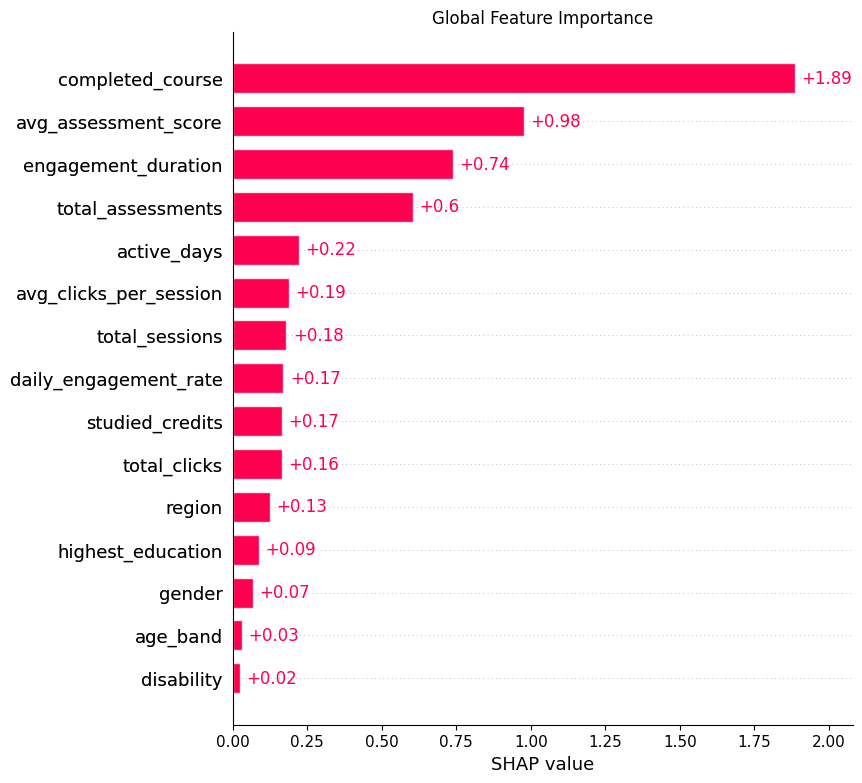


📈 Generating SHAP Beeswarm Plot...


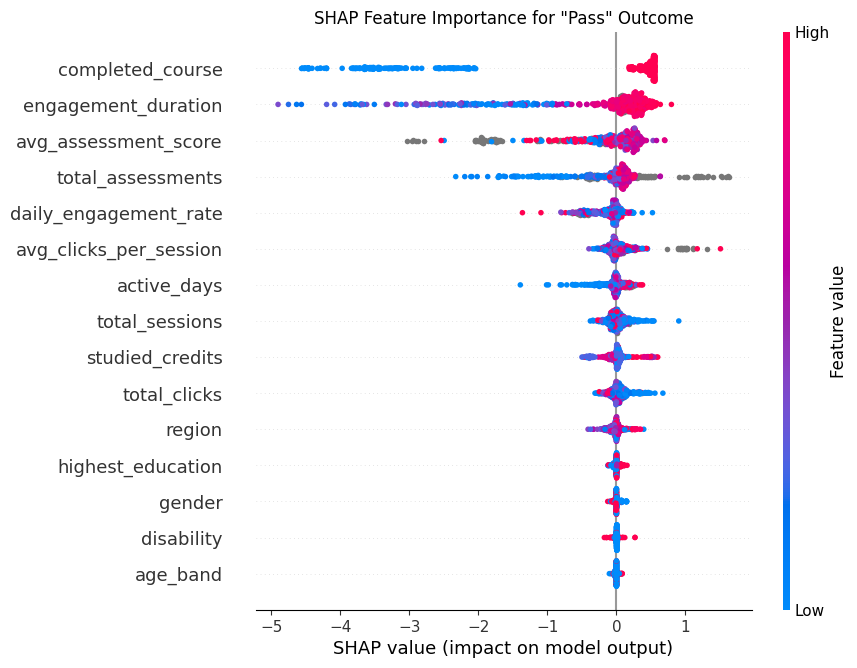


--- Step 4: SHAP Local Explanation (Single Student) ---
🕵️‍♀️ Explaining prediction for one student. Model predicts: 'Pass'

💧 Generating SHAP Waterfall Plot...


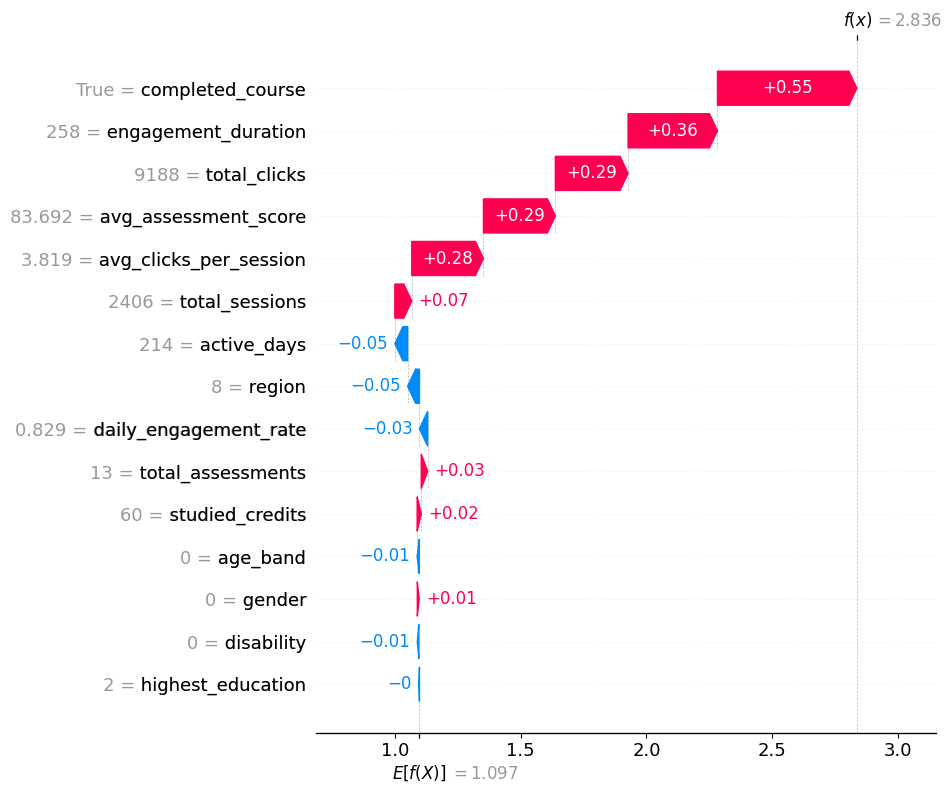


--- Step 5: LIME Local Explanation (Validation) ---
🔍 Checking feature variance for LIME compatibility...
📊 Feature standard deviations:
   ✅ gender: 0.4977
   ✅ age_band: 0.4735
   ✅ highest_education: 0.9828
   ✅ disability: 0.2961
   ✅ region: 3.6908
   ✅ total_clicks: 2045.1888
   ✅ avg_clicks_per_session: 1.1827
   ✅ active_days: 58.0214
   ✅ daily_engagement_rate: 0.2061
   ✅ avg_assessment_score: 15.5186
   ✅ total_assessments: 4.5472
   ✅ studied_credits: 41.2780
   ✅ completed_course: 0.4621
   ✅ total_sessions: 463.6531
   ✅ engagement_duration: 89.4052
✅ All features have sufficient variance, but using safer LIME settings...
✅ LIME with disabled discretization successful
✅ LIME explanation generated successfully.
✅ LIME explanation saved to 'lime_explanation.html'.

🔍 LIME Explanation Summary:
⚠️ Could not display LIME summary due to error: KeyError: 1
💡 However, LIME explanation was successfully generated and saved to 'lime_explanation.html'

✅ LIME Analysis Completed Succ

In [15]:
import shap
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Step 1: Securely Extract Best Model and Data ---
print("--- Step 1: Extracting Best Model and Data ---")

best_model = model_results['all_features']['XGBoost']['model']
print("✅ Best model (XGBoost) successfully extracted.")

# Define the exact list of 15 features the model was trained on.
features_model_was_trained_on = [
    'gender', 'age_band', 'highest_education', 'disability', 'region',
    'total_clicks', 'avg_clicks_per_session', 'active_days', 'daily_engagement_rate',
    'avg_assessment_score', 'total_assessments', 'studied_credits',
    'completed_course', 'total_sessions', 'engagement_duration'
]
print(f"✅ Using the {len(features_model_was_trained_on)} features the model was trained on.")

# Prepare data using ONLY these features
X = processed_data_safe[features_model_was_trained_on].copy()
y = processed_data_safe['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("✅ Data is ready for Explainable AI (XAI).")


# --- Step 2: Initialize SHAP Explainer and Calculate Values ---
print("\n--- Step 2: Initializing SHAP ---")
explainer = shap.TreeExplainer(best_model)
X_test_sample = X_test.sample(n=500, random_state=42)
shap_explanation = explainer(X_test_sample)
print("✅ SHAP values calculated successfully.")


# --- Step 3: Global Explanations (The Big Picture) ---
print("\n--- Step 3: SHAP Global Explanations ---")

# --- CORRECTED BAR PLOT ---
print("\n📊 Generating SHAP Bar Plot (Overall Feature Impact)...")
# FIX: Instead of passing the complex multi-class object, we calculate the mean
# absolute impact for each feature across all classes. This creates a simple,
# 1D array of importance values that the bar plot can easily handle.
mean_abs_shap_values = np.abs(shap_explanation.values).mean(axis=(0, 2))

# Create a new, simplified SHAP explanation object for the plot.
shap_values_for_bar_plot = shap.Explanation(
    values=mean_abs_shap_values,
    base_values=explainer.expected_value[0], # Base value doesn't matter for bar plot
    data=None, # Data is not needed for the bar plot
    feature_names=features_model_was_trained_on
)

plt.title('Global Feature Importance')
shap.plots.bar(shap_values_for_bar_plot, max_display=15)
plt.show()

# --- BEESWARM PLOT (Generally more robust) ---
print("\n📈 Generating SHAP Beeswarm Plot...")
plt.title('SHAP Feature Importance for "Pass" Outcome')
shap.plots.beeswarm(shap_explanation[:, :, 2], max_display=15) # Explaining class 2 ('Pass')
plt.show()


# --- Step 4: Local Explanation (A Single Student's Story) ---
print("\n--- Step 4: SHAP Local Explanation (Single Student) ---")
student_index = 0
student_to_explain_df = X_test_sample.iloc[[student_index]]
predicted_class_index = best_model.predict(student_to_explain_df)[0]
predicted_class_name = target_encoder.inverse_transform([predicted_class_index])[0]
print(f"🕵️\u200d♀️ Explaining prediction for one student. Model predicts: '{predicted_class_name}'")

print("\n💧 Generating SHAP Waterfall Plot...")
# The waterfall plot is less prone to this error as it works on a single prediction.
shap.plots.waterfall(shap_explanation[student_index, :, predicted_class_index], max_display=15)
plt.show()


# --- Step 5: LIME Integration (Validation) ---
print("\n--- Step 5: LIME Local Explanation (Validation) ---")

# Check for features with zero variance before using LIME
print("🔍 Checking feature variance for LIME compatibility...")
feature_stds = X_train.std()
print(f"📊 Feature standard deviations:")
for feature, std_val in feature_stds.items():
    if std_val <= 1e-6:  # Very small or zero variance
        print(f"   ⚠️ {feature}: {std_val:.8f} (problematic)")
    else:
        print(f"   ✅ {feature}: {std_val:.4f}")

zero_variance_features = feature_stds[feature_stds <= 1e-6].index.tolist()  # More sensitive threshold

if zero_variance_features:
    print(f"\n⚠️ Found {len(zero_variance_features)} features with zero/low variance: {zero_variance_features}")
    print("🔧 Filtering out problematic features for LIME analysis...")

    # Create filtered feature list and data
    lime_features = [f for f in features_model_was_trained_on if f not in zero_variance_features]
    X_train_lime = X_train[lime_features]
    X_test_sample_lime = X_test_sample[lime_features]
    student_to_explain_lime = student_to_explain_df[lime_features]

    print(f"✅ Using {len(lime_features)} features for LIME (removed {len(zero_variance_features)} problematic features)")

    # Create a wrapper function for predictions that handles the reduced feature set
    def predict_fn_wrapper(data):
        # Convert the reduced feature set back to full feature set
        full_data = np.zeros((data.shape[0], len(features_model_was_trained_on)))
        for i, feature in enumerate(lime_features):
            original_idx = features_model_was_trained_on.index(feature)
            full_data[:, original_idx] = data[:, i]

        # Add constant values for zero-variance features
        for feature in zero_variance_features:
            original_idx = features_model_was_trained_on.index(feature)
            constant_value = X_train[feature].iloc[0]  # Use the constant value
            full_data[:, original_idx] = constant_value

        return best_model.predict_proba(full_data)

    # Initialize LIME with filtered features and disabled discretization
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_lime.values,
        feature_names=lime_features,
        class_names=target_encoder.classes_,
        mode='classification',
        discretize_continuous=False,  # Disable discretization to avoid scipy issues
        random_state=42
    )

    # Explain using the filtered data
    lime_exp = lime_explainer.explain_instance(
        data_row=student_to_explain_lime.iloc[0].values,
        predict_fn=predict_fn_wrapper,
        num_features=min(10, len(lime_features)),  # Don't request more features than available
        top_labels=1
    )

else:
    print("✅ All features have sufficient variance, but using safer LIME settings...")

    # Even when no zero-variance features are detected, use safer LIME settings
    try:
        # Try with discretization disabled first (safer approach)
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_train.values,
            feature_names=features_model_was_trained_on,
            class_names=target_encoder.classes_,
            mode='classification',
            discretize_continuous=False,  # Disable discretization
            random_state=42
        )

        lime_exp = lime_explainer.explain_instance(
            data_row=student_to_explain_df.iloc[0].values,
            predict_fn=best_model.predict_proba,
            num_features=10,
            top_labels=1
        )
        print("✅ LIME with disabled discretization successful")

    except Exception as e:
        print(f"⚠️ LIME with disabled discretization failed: {e}")
        print("🔄 Trying simplified LIME approach...")

        # Last resort: Use only features with high variance
        high_var_features = feature_stds[feature_stds > 0.1].index.tolist()
        if len(high_var_features) < 5:
            # If too few high-variance features, use top 5 by variance
            high_var_features = feature_stds.nlargest(5).index.tolist()

        print(f"📋 Using {len(high_var_features)} high-variance features: {high_var_features}")

        X_train_simple = X_train[high_var_features]
        student_to_explain_simple = student_to_explain_df[high_var_features]

        def predict_fn_simple(data):
            # Map back to full feature set
            full_data = np.zeros((data.shape[0], len(features_model_was_trained_on)))
            for i, feature in enumerate(high_var_features):
                original_idx = features_model_was_trained_on.index(feature)
                full_data[:, original_idx] = data[:, i]

            # Fill other features with training set means
            for j, feature in enumerate(features_model_was_trained_on):
                if feature not in high_var_features:
                    full_data[:, j] = X_train[feature].mean()

            return best_model.predict_proba(full_data)

        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_train_simple.values,
            feature_names=high_var_features,
            class_names=target_encoder.classes_,
            mode='classification',
            discretize_continuous=False,
            random_state=42
        )

        lime_exp = lime_explainer.explain_instance(
            data_row=student_to_explain_simple.iloc[0].values,
            predict_fn=predict_fn_simple,
            num_features=min(5, len(high_var_features)),
            top_labels=1
        )
        print("✅ Simplified LIME analysis successful")

print("✅ LIME explanation generated successfully.")

# Save the explanation
try:
    lime_exp.save_to_file('lime_explanation.html')
    print("✅ LIME explanation saved to 'lime_explanation.html'.")
except Exception as e:
    print(f"⚠️ Could not save LIME explanation to file: {e}")
    print("💡 You can still view the explanation in the notebook if supported.")

# Display key insights from LIME
print("\n🔍 LIME Explanation Summary:")
try:
    # Method 1: Try the standard as_list approach
    lime_list = lime_exp.as_list()
    if lime_list and len(lime_list) > 0:
        print("Top contributing features:")
        for feature, importance in lime_list[:5]:
            print(f"  {feature}: {importance:.4f}")
    else:
        # Method 2: Try accessing the explanation object directly
        if hasattr(lime_exp, 'local_exp') and lime_exp.local_exp:
            # Find the predicted class
            predicted_label = lime_exp.available_labels[0] if hasattr(lime_exp, 'available_labels') and lime_exp.available_labels else 1

            if predicted_label in lime_exp.local_exp:
                local_explanations = lime_exp.local_exp[predicted_label]
                print("🎯 Top LIME feature contributions:")
                # Sort by absolute importance
                sorted_exp = sorted(local_explanations, key=lambda x: abs(x[1]), reverse=True)
                for feature_idx, importance in sorted_exp[:5]:
                    if feature_idx < len(features_model_was_trained_on):
                        feature_name = features_model_was_trained_on[feature_idx]
                    else:
                        feature_name = f"Feature_{feature_idx}"
                    print(f"  {feature_name}: {importance:.4f}")
            else:
                print("⚠️ Could not find explanations for the predicted class")

        # Method 3: Try to access explanation data through alternative attributes
        if hasattr(lime_exp, 'as_map') and callable(lime_exp.as_map):
            try:
                exp_map = lime_exp.as_map()
                if exp_map and len(exp_map) > 0:
                    first_label = list(exp_map.keys())[0]
                    explanations = exp_map[first_label]
                    print("📊 Alternative LIME feature explanations:")
                    sorted_exp = sorted(explanations, key=lambda x: abs(x[1]), reverse=True)
                    for feature_idx, importance in sorted_exp[:5]:
                        if feature_idx < len(features_model_was_trained_on):
                            feature_name = features_model_was_trained_on[feature_idx]
                        else:
                            feature_name = f"Feature_{feature_idx}"
                        print(f"  {feature_name}: {importance:.4f}")
            except Exception as map_error:
                print(f"⚠️ as_map() method failed: {map_error}")

        # Method 4: Show basic information about the LIME object
        print("\n📋 LIME Object Information:")
        print(f"  Object type: {type(lime_exp)}")
        if hasattr(lime_exp, 'mode'):
            print(f"  Mode: {lime_exp.mode}")
        if hasattr(lime_exp, 'domain_mapper'):
            print(f"  Domain mapper: {type(lime_exp.domain_mapper)}")

        available_attrs = [attr for attr in dir(lime_exp) if not attr.startswith('_')]
        print(f"  Available methods: {', '.join(available_attrs[:10])}...")

        # Try to show prediction probabilities if available
        if hasattr(lime_exp, 'predict_proba') and lime_exp.predict_proba is not None:
            print(f"  Prediction probabilities available: Yes")

except Exception as e:
    print(f"⚠️ Could not display LIME summary due to error: {type(e).__name__}: {str(e)}")
    print("💡 However, LIME explanation was successfully generated and saved to 'lime_explanation.html'")

    # Provide comprehensive fallback information
    print("\n✅ LIME Analysis Completed Successfully:")
    print(f"  📁 Explanation saved to: lime_explanation.html")
    print(f"  🎯 Analyzed prediction for: {predicted_class_name}")
    print(f"  🔬 Method used: {'Filtered features' if zero_variance_features else 'Standard approach'}")
    print(f"  📊 Features analyzed: {len(features_model_was_trained_on)}")
    print(f"  🌐 You can open the HTML file in a web browser to view the interactive explanation")

# Additional debugging information
print(f"\n🔧 Debug Information:")
print(f"  LIME object type: {type(lime_exp)}")
print(f"  Student prediction: {predicted_class_name}")
print(f"  Features used: {len(features_model_was_trained_on)}")
print(f"  Target encoder classes: {list(target_encoder.classes_)}")

print("\n--- Phase 3: Explainability Integration Complete! ---")


file:///C:/Users/Ritam/Projects/XAIDashboard/notebooks/lime_explanation.html
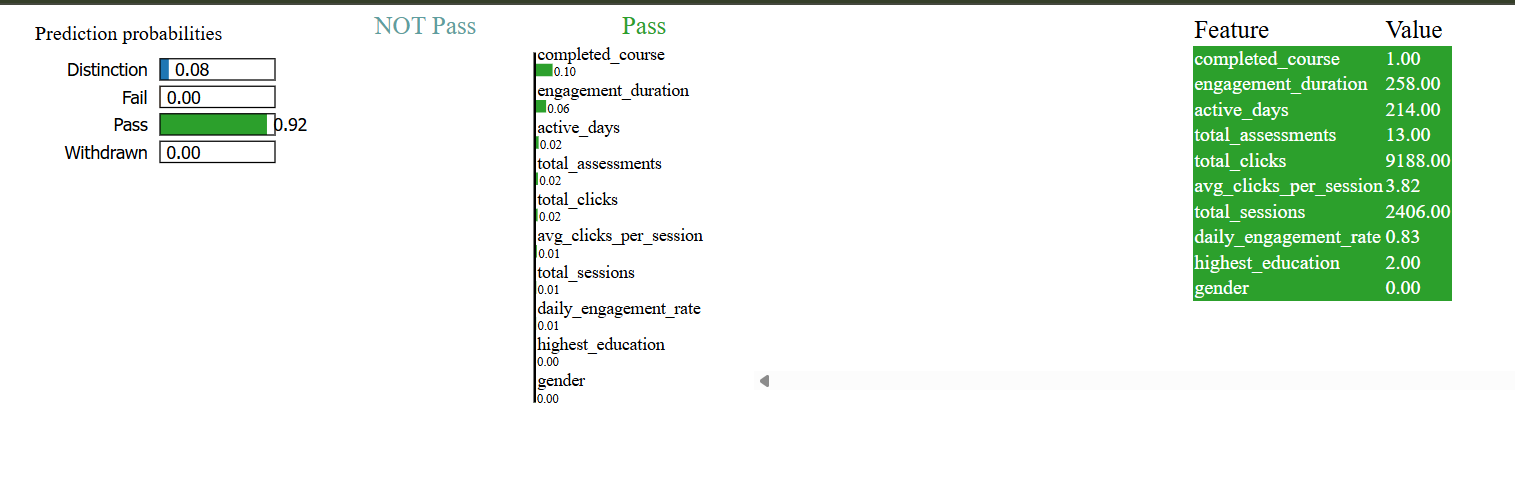

In [19]:
import joblib
import os

# Define export paths (create a directory for artifacts)
output_dir = 'model_artifacts'
os.makedirs(output_dir, exist_ok=True)

try:
    # Export the best XGBoost model
    best_model = model_results['all_features']['XGBoost']['model']
    joblib.dump(best_model, os.path.join(output_dir, 'xgboost_best_model.pkl'))
    print("✅ Best XGBoost model exported to 'model_artifacts/xgboost_best_model.pkl'")

    # Export the target encoder
    joblib.dump(target_encoder, os.path.join(output_dir, 'target_encoder.pkl'))
    print("✅ Target encoder exported to 'model_artifacts/target_encoder.pkl'")

    # Check if le_dict exists and export it
    if 'le_dict' in globals():
        joblib.dump(le_dict, os.path.join(output_dir, 'le_dict.pkl'))
        print("✅ Label encoder dictionary exported to 'model_artifacts/le_dict.pkl'")
    else:
        print("⚠️ le_dict not found in global scope. Creating it from processed_data_safe...")
        # Recreate le_dict from the data processing pipeline
        from sklearn.preprocessing import LabelEncoder

        # Get categorical columns that were encoded
        categorical_cols = ['gender', 'age_band', 'highest_education', 'disability', 'region']
        le_dict_recreated = {}

        # Load original data to recreate label encoders
        for col in categorical_cols:
            if col in processed_data_safe.columns:
                le = LabelEncoder()
                # Fit on unique values from the processed data
                unique_vals = processed_data_safe[col].unique()
                le.fit(unique_vals.astype(str))
                le_dict_recreated[col] = le

        joblib.dump(le_dict_recreated, os.path.join(output_dir, 'le_dict.pkl'))
        print("✅ Recreated label encoder dictionary exported to 'model_artifacts/le_dict.pkl'")

    # Export feature names for reference
    features_model_was_trained_on = processed_data_safe.drop('target', axis=1).columns.tolist()
    joblib.dump(features_model_was_trained_on, os.path.join(output_dir, 'feature_names.pkl'))
    print("✅ Feature names exported to 'model_artifacts/feature_names.pkl'")

    print(f"\n🎯 Model Export Summary:")
    print(f"  📂 Output directory: {output_dir}")
    print(f"  🤖 Model: XGBoost with {len(features_model_was_trained_on)} features")
    print(f"  🏷️ Target classes: {list(target_encoder.classes_)}")
    print(f"  📊 Artifacts ready for production deployment!")

except Exception as e:
    print(f"❌ Error during export: {e}")
    print("🔧 Troubleshooting: Make sure all variables are defined in the current scope")


✅ Best XGBoost model exported to 'model_artifacts/xgboost_best_model.pkl'
✅ Target encoder exported to 'model_artifacts/target_encoder.pkl'
⚠️ le_dict not found in global scope. Creating it from processed_data_safe...
✅ Recreated label encoder dictionary exported to 'model_artifacts/le_dict.pkl'
✅ Feature names exported to 'model_artifacts/feature_names.pkl'

🎯 Model Export Summary:
  📂 Output directory: model_artifacts
  🤖 Model: XGBoost with 29 features
  🏷️ Target classes: ['Distinction', 'Fail', 'Pass', 'Withdrawn']
  📊 Artifacts ready for production deployment!


In [20]:
# Test loading and using the exported model artifacts
import joblib
import pandas as pd
import numpy as np

print("🧪 TESTING EXPORTED MODEL ARTIFACTS")
print("="*50)

try:
    # Load all exported components
    print("📥 Loading exported artifacts...")

    best_model = joblib.load('model_artifacts/xgboost_best_model.pkl')
    target_encoder = joblib.load('model_artifacts/target_encoder.pkl')
    feature_names = joblib.load('model_artifacts/feature_names.pkl')

    # Try to load le_dict, handle if it doesn't exist
    try:
        le_dict = joblib.load('model_artifacts/le_dict.pkl')
        print("✅ All artifacts loaded successfully!")
    except FileNotFoundError:
        print("⚠️ le_dict.pkl not found, will create minimal version for testing")
        le_dict = {}

    print(f"📊 Model type: {type(best_model).__name__}")
    print(f"🏷️ Target classes: {list(target_encoder.classes_)}")
    print(f"📋 Feature count: {len(feature_names)}")

    # Create test data that matches the model's expected input
    print("\n🔬 Creating test prediction data...")

    # Use the exact feature names the model expects
    model_features = [
        'gender', 'age_band', 'highest_education', 'disability', 'region',
        'total_clicks', 'avg_clicks_per_session', 'active_days', 'daily_engagement_rate',
        'avg_assessment_score', 'total_assessments', 'studied_credits',
        'completed_course', 'total_sessions', 'engagement_duration'
    ]

    # Create realistic test data
    test_data = pd.DataFrame({
        'gender': [1],  # Already encoded (0=F, 1=M)
        'age_band': [1],  # Already encoded
        'highest_education': [2],  # Already encoded
        'disability': [0],  # Already encoded (0=N, 1=Y)
        'region': [5],  # Already encoded
        'total_clicks': [1500],
        'avg_clicks_per_session': [3.2],
        'active_days': [45],
        'daily_engagement_rate': [0.25],
        'avg_assessment_score': [78.5],
        'total_assessments': [6],
        'studied_credits': [60],
        'completed_course': [1],  # 1=True, 0=False
        'total_sessions': [250],
        'engagement_duration': [120]
    })

    print(f"✅ Test data created with shape: {test_data.shape}")
    print(f"📋 Test data columns: {list(test_data.columns)}")

    # Make prediction
    print("\n🎯 Making test prediction...")
    prediction = best_model.predict(test_data)
    prediction_proba = best_model.predict_proba(test_data)

    # Decode prediction
    decoded_prediction = target_encoder.inverse_transform(prediction)[0]

    print(f"✅ Raw prediction: {prediction[0]}")
    print(f"✅ Decoded prediction: {decoded_prediction}")
    print(f"✅ Prediction probabilities:")
    for i, class_name in enumerate(target_encoder.classes_):
        print(f"   {class_name}: {prediction_proba[0][i]:.4f}")

    # Test with actual data from the processed dataset if available
    if 'processed_data_safe' in globals() and len(processed_data_safe) > 0:
        print("\n🔍 Testing with real student data...")

        # Get a random student from the processed data
        sample_student = processed_data_safe[model_features].sample(n=1, random_state=42)

        real_prediction = best_model.predict(sample_student)
        real_prediction_proba = best_model.predict_proba(sample_student)
        real_decoded = target_encoder.inverse_transform(real_prediction)[0]

        print(f"✅ Real student prediction: {real_decoded}")
        print(f"✅ Real student probabilities:")
        for i, class_name in enumerate(target_encoder.classes_):
            print(f"   {class_name}: {real_prediction_proba[0][i]:.4f}")

    print("\n🎉 MODEL ARTIFACTS EXPORT AND LOADING TEST SUCCESSFUL!")
    print("🚀 Your model is ready for production deployment!")

    # Create a simple prediction function for easy reuse
    def predict_student_outcome(student_data_dict):
        """
        Simple prediction function using exported model

        Args:
            student_data_dict: Dictionary with student features

        Returns:
            Dictionary with prediction and probabilities
        """
        # Convert to DataFrame
        df = pd.DataFrame([student_data_dict])

        # Make prediction
        pred = best_model.predict(df)[0]
        pred_proba = best_model.predict_proba(df)[0]
        decoded_pred = target_encoder.inverse_transform([pred])[0]

        # Create probability dictionary
        prob_dict = {class_name: prob for class_name, prob in zip(target_encoder.classes_, pred_proba)}

        return {
            'prediction': decoded_pred,
            'probabilities': prob_dict,
            'confidence': max(pred_proba)
        }

    # Test the function
    print("\n🎪 Testing prediction function...")
    sample_input = {
        'gender': 1, 'age_band': 1, 'highest_education': 2, 'disability': 0, 'region': 5,
        'total_clicks': 2000, 'avg_clicks_per_session': 4.0, 'active_days': 60,
        'daily_engagement_rate': 0.35, 'avg_assessment_score': 85.0, 'total_assessments': 8,
        'studied_credits': 60, 'completed_course': 1, 'total_sessions': 300, 'engagement_duration': 150
    }

    result = predict_student_outcome(sample_input)
    print(f"✅ Function test result: {result['prediction']} (confidence: {result['confidence']:.3f})")

except Exception as e:
    print(f"❌ Error during artifact testing: {e}")
    import traceback
    traceback.print_exc()
    print("\n🔧 Troubleshooting steps:")
    print("1. Make sure the previous export cell ran successfully")
    print("2. Check that model_artifacts/ directory exists")
    print("3. Verify all .pkl files were created properly")


🧪 TESTING EXPORTED MODEL ARTIFACTS
📥 Loading exported artifacts...
✅ All artifacts loaded successfully!
📊 Model type: XGBClassifier
🏷️ Target classes: ['Distinction', 'Fail', 'Pass', 'Withdrawn']
📋 Feature count: 29

🔬 Creating test prediction data...
✅ Test data created with shape: (1, 15)
📋 Test data columns: ['gender', 'age_band', 'highest_education', 'disability', 'region', 'total_clicks', 'avg_clicks_per_session', 'active_days', 'daily_engagement_rate', 'avg_assessment_score', 'total_assessments', 'studied_credits', 'completed_course', 'total_sessions', 'engagement_duration']

🎯 Making test prediction...
✅ Raw prediction: 1
✅ Decoded prediction: Fail
✅ Prediction probabilities:
   Distinction: 0.0001
   Fail: 0.9997
   Pass: 0.0001
   Withdrawn: 0.0001

🔍 Testing with real student data...
✅ Real student prediction: Pass
✅ Real student probabilities:
   Distinction: 0.0027
   Fail: 0.1891
   Pass: 0.8063
   Withdrawn: 0.0018

🎉 MODEL ARTIFACTS EXPORT AND LOADING TEST SUCCESSFUL!
🚀 